# Projet : Walmart sales

Description de l'entreprise 📇  
Walmart Inc. est une multinationale américaine de la vente au détail qui exploite une chaîne d'hypermarchés, de grands magasins discount et d'épiceries aux États-Unis. Son siège social est situé à Bentonville, dans l'Arkansas. L'entreprise a été fondée par Sam Walton en 1962.

Projet 🚧  
Le service marketing de Walmart vous a demandé de créer un modèle d'apprentissage automatique capable d'estimer les ventes hebdomadaires de ses magasins, avec la plus grande précision possible. Ce modèle leur permettrait de mieux comprendre l'influence des indicateurs économiques sur les ventes et pourrait servir à planifier leurs futures campagnes marketing.

Objectifs 🎯  
Le projet peut être divisé en trois étapes :  
Partie 1 : réaliser une EDA et tous les prétraitements nécessaires pour préparer les données au machine learning   
Partie 2 : former un modèle de régression linéaire (référence)  
Partie 3 : éviter le surapprentissage en entraînant un modèle de régression régularisé  

Portée de ce projet 🖼️  
Pour ce projet, vous travaillerez avec un ensemble de données contenant des informations sur les ventes hebdomadaires de différents magasins Walmart, ainsi que d'autres variables telles que le taux de chômage ou le prix du carburant, qui pourraient être utiles pour prédire le volume des ventes. 
Cet ensemble de données est issu d'un concours Kaggle, mais nous avons apporté quelques modifications par rapport aux données d'origine.

----

Import des librairies

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff


Chargement du dataset

In [3]:
df = pd.read_csv("src/Walmart_Store_sales.csv")

In [4]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


# Partie 1 : EDA et prétraitement des données

In [5]:
df.shape

(150, 8)

In [6]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB


Etude des colonnes:
- "Store" : id du magasin, à transformer en variable catégorielle
- "Date" : date à mettre au format datetime, et créer Année, Mois, Semaine
- "Weekly_Sales" : vente hebdomadaire, variable cible, supprimer les lignes des valeurs manquantes
- "Holiday_Flag" : semaine de vacances, variable booléenne
- "Temperature" : température en Fahrenheit le jour de la vente, variable numérique
- "Fuel_Price" : prix carburant au cours de la semaine
- "CPI" : indice des prix à la consommation, mesure l'évolution du niveau moyen des prix des biens et services consommés par les ménages, variable numérique
- "Unemployment" : taux de chômage, variable numérique

In [8]:
# Modification des types des colonnes
df["Store"] = df["Store"].astype('str')
df["Date"] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df["Holiday_Flag"] = df["Holiday_Flag"].astype('bool')

In [9]:
# Suppresion des lignes lorsque Weekly_Sales ou Date est NaN 
df = df.dropna(subset=['Weekly_Sales', 'Date'])

In [10]:
df.shape

(118, 8)

In [11]:
# Création de colonnes à partir de Date
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Weekofyear'] = df['Date'].dt.isocalendar().week

In [12]:
# Suppression des lignes contenant des valeurs invalides ou des valeurs aberrantes pour les colonnes :   
# 'Temperature','Fuel_Price', 'CPI', 'Unemployment'
for col in ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']:
       mini = df[col].mean() - 3 * df[col].std()
       maxi = df[col].mean() + 3 * df[col].std()
       df = df.drop(df.loc[(df[col] < mini) | (df[col] > maxi)].index, axis=0)

In [13]:
df.shape

(113, 11)

In [14]:
# Tri du dataframe par date
df = df.sort_values(by='Date').reset_index(drop=True)

In [15]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Weekofyear
0,3.0,2010-02-05,461622.22,False,45.71,2.572,214.424881,7.368,2010,2,5
1,8.0,2010-02-12,994801.40,True,33.34,2.548,214.621419,6.299,2010,2,6
2,1.0,2010-02-12,1641957.44,True,38.51,2.548,211.242170,8.106,2010,2,6
3,2.0,2010-02-19,2124451.54,False,39.69,2.514,210.945160,NaN,2010,2,7
4,15.0,2010-02-19,660838.75,False,NaN,2.909,131.637000,NaN,2010,2,7


In [16]:
# Statistiques de base
df.describe(include="all").transpose()

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Store,113,19,3.0,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,113,NaN,NaN,NaN,2011-04-24 21:52:33.982300928,2010-02-05 00:00:00,2010-07-30 00:00:00,2011-04-22 00:00:00,2012-01-13 00:00:00,2012-10-19 00:00:00,NaN
Weekly_Sales,113.0,NaN,NaN,NaN,1267414.773982,268929.03,563460.77,1420405.41,1847430.96,2771397.17,674682.427099
Holiday_Flag,113,2,False,97,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Temperature,103.0,NaN,NaN,NaN,60.197087,18.79,45.02,61.11,75.255,91.65,17.878511
Fuel_Price,102.0,NaN,NaN,NaN,3.273863,2.514,2.81475,3.3025,3.6835,4.17,0.481421
CPI,104.0,NaN,NaN,NaN,180.105389,126.111903,132.579257,197.500965,214.809008,226.968844,39.201866
Unemployment,102.0,NaN,NaN,NaN,7.376775,5.143,6.64225,7.4045,8.09675,9.524,0.973078
Year,113.0,NaN,NaN,NaN,2010.831858,2010.0,2010.0,2011.0,2012.0,2012.0,0.822699
Month,113.0,NaN,NaN,NaN,6.274336,1.0,4.0,6.0,9.0,12.0,3.179869


In [17]:
# Nombre de valeurs manquantes
df.isna().sum()

Store            0
Date             0
Weekly_Sales     0
Holiday_Flag     0
Temperature     10
Fuel_Price      11
CPI              9
Unemployment    11
Year             0
Month            0
Weekofyear       0
dtype: int64

In [18]:
# Pourcentage des valeurs manquantes
round(100 * df.isna().sum() / df.shape[0], 2)

Store           0.00
Date            0.00
Weekly_Sales    0.00
Holiday_Flag    0.00
Temperature     8.85
Fuel_Price      9.73
CPI             7.96
Unemployment    9.73
Year            0.00
Month           0.00
Weekofyear      0.00
dtype: float64

<Axes: >

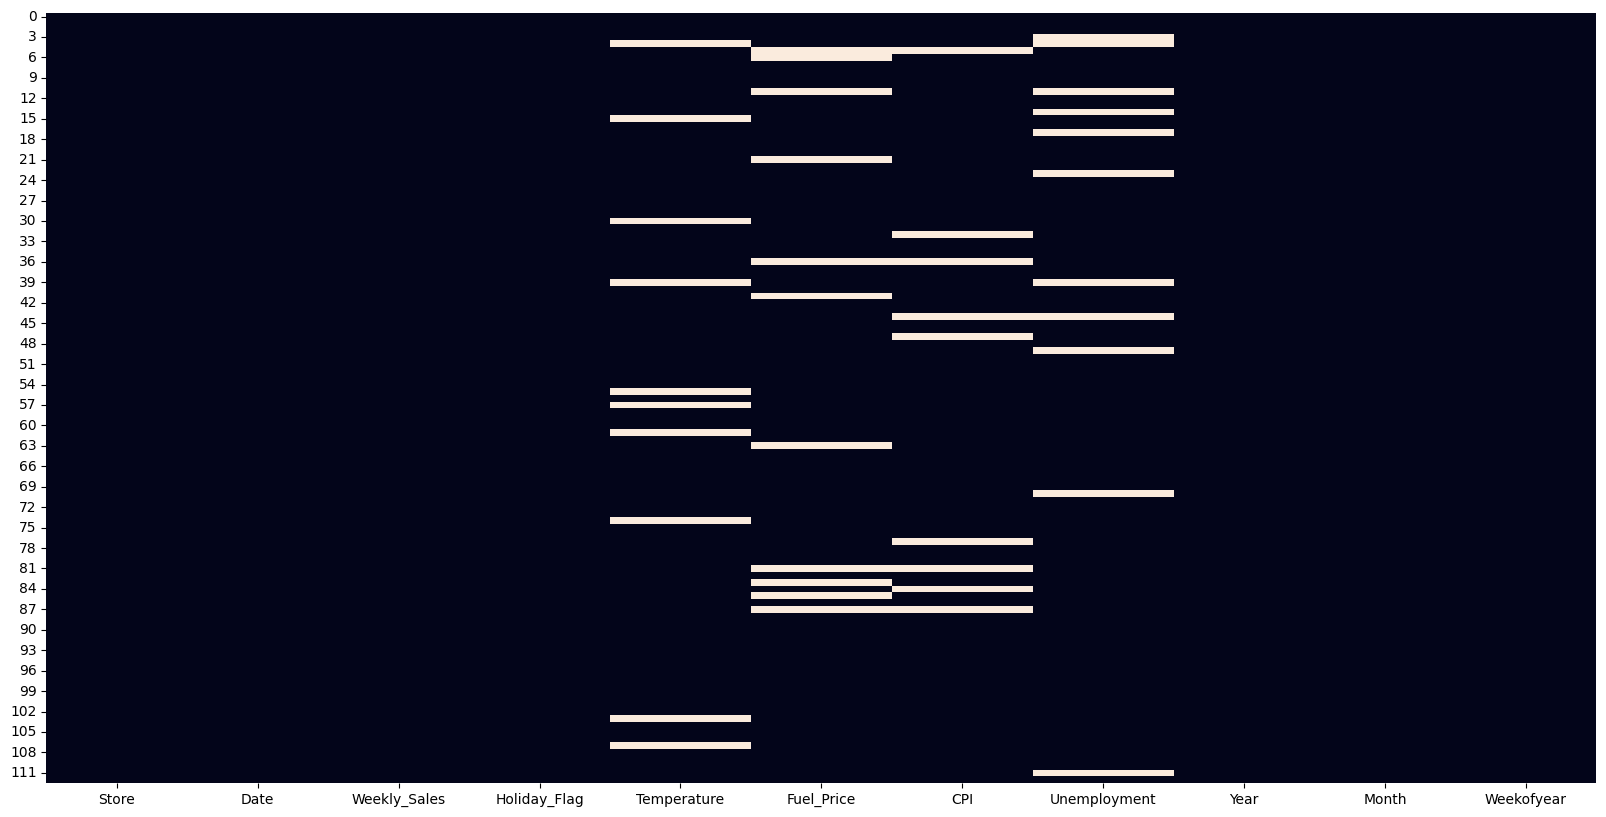

In [19]:
# Visualisation des données manquantes
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(), cbar=False)

Il n'y a pas de lignes entières avec des valeurs manquantes. Cela sera géré pendant le pré-processing.

In [20]:
# Nombre de doublons
df.duplicated().sum()

np.int64(0)

### Distribution de la variable cible

In [21]:
fig = px.box(df, y ='Weekly_Sales' ,
             title= 'Distribution de Weekly_Sales')
fig.show()

In [22]:
fig = px.box(df.sort_values(by='Store'), x='Store', y= 'Weekly_Sales' )
fig.update_layout(
    xaxis=dict(tickmode='linear'),
    title = "Distribution de Weekly_Sales par Store",
    height=500
)
fig.show()

## Weekly_Sales dans le temps

In [23]:
print(df['Date'].min())
print(df['Date'].max())
print(df['Date'].max()-df['Date'].min())

2010-02-05 00:00:00
2012-10-19 00:00:00
987 days 00:00:00


In [24]:
fig = go.Figure(
    data = go.Scatter(
        x = df['Date'], y=df['Weekly_Sales'], 
        mode='lines'
        ),
    layout = go.Layout(
        title = go.layout.Title(text = "Weekly_Sales"),
        xaxis = go.layout.XAxis( rangeslider = go.layout.xaxis.Rangeslider(visible = True))
    )
)

fig.show()

In [25]:
fig = px.box(df.sort_values('Month'),x= 'Month' , y = 'Weekly_Sales' )
fig.update_layout(
    xaxis=dict(tickmode='linear'), 
    title = "Weekly_Sales by Month" 
)
fig.show()

In [26]:
fig = px.bar(df, y = 'Weekly_Sales', x='Weekofyear',
             title='Weekly_Sales')
fig.show()

In [27]:
df['Store'].value_counts()

Store
3.0     10
13.0     9
14.0     9
1.0      8
19.0     8
5.0      7
7.0      7
18.0     7
4.0      6
6.0      6
8.0      6
2.0      6
17.0     5
9.0      4
20.0     4
16.0     4
15.0     3
10.0     3
11.0     1
Name: count, dtype: int64

In [28]:
df['Holiday_Flag'].value_counts()

Holiday_Flag
False    97
True     16
Name: count, dtype: int64

In [29]:
px.scatter(df, x='Temperature', y='Weekly_Sales')

In [30]:

fig = make_subplots(
    rows=4, cols=1, shared_xaxes=True,
    subplot_titles=["Fuel Price", "CPI", "Unemployment", "Weekly Sales"]
)

# Créer et ajouter les traces avec Plotly Express
fig1 = px.line(df.sort_values('Date'), x="Date", y="Fuel_Price")
fig2 = px.line(df.sort_values('Date'), x="Date", y="CPI")
fig3 = px.line(df.sort_values('Date'), x="Date", y="Unemployment")
fig4 = px.line(df.sort_values('Date'), x="Date", y="Weekly_Sales")

# Ajouter les traces dans les subplots
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=2, col=1)
fig.add_trace(fig3.data[0], row=3, col=1)
fig.add_trace(fig4.data[0], row=4, col=1)

# Mise en page
#fig.update_layout(title_text="Évolution des indicateurs économiques", height=800)

fig.update_layout(
    title_text="Évolution des indicateurs économiques",
    height=800,
    )

# Afficher le graphique
fig.show()


In [31]:
px.scatter(df, x='Fuel_Price', y='Weekly_Sales')

In [32]:
px.scatter(df, x='CPI', y='Weekly_Sales', color='Unemployment', color_continuous_scale=['green','orange','red'])

In [33]:
fig = px.scatter(df,  x="Weekly_Sales", y="Unemployment")
fig.show()

In [34]:
# Suppression de la colonne Date
df = df.drop('Date', axis=1)

In [35]:
# Correlation matrix
corr_matrix = df.corr().round(2)
fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())
fig.show()

# Partie 2 : Modélisation (régression linéaire)

### Modèle de référence 

In [36]:
# Modèle de référence avec CPI, variable la plus corrélée à la variable cible
X = df[['CPI']].fillna(df['CPI'].mean())
y = df['Weekly_Sales']

In [37]:
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# Régression linéaire : entrainement du modèle
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [39]:
# évaluation du modèle pour l'ensemble d'entraînement
y_train_pred = model.predict(X_train)
r2 = r2_score(y_train, y_train_pred)
print("La performance du Modèle pour le set de Train")
print("---------------------------------------------")
print(f"Score R² : {r2}")
print("\n")

# évaluation du modèle pour le set de test
y_test_pred = model.predict(X_test)
r2 = r2_score(y_test, y_test_pred)
print("La performance du Modèle pour le set de Test")
print("--------------------------------------------")
print(f"Score R² : {r2}")

La performance du Modèle pour le set de Train
---------------------------------------------
Score R² : 0.1183007351029034


La performance du Modèle pour le set de Test
--------------------------------------------
Score R² : 0.05773355044646056


### Modèle avec toutes les colonnes

In [40]:
# Séparation de la variable cible des variables explicatives
X = df.drop(columns=["Weekly_Sales"])
y = df["Weekly_Sales"]

In [41]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
num_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month','Weekofyear']
cat_features = ['Store']
passthrough_features = ['Holiday_Flag']


# Pipeline pour les colonnes numériques
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")), 
    ("scaler", StandardScaler())
])

# Pipeline pour les colonnes catégoriques
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")), 
    ("onehot", OneHotEncoder(drop="first")) 
])

# Transformation des données
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features),
    ("pass", "passthrough", passthrough_features)
])

# Application de la transformation
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Nom des colonnes transformées
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['num__Temperature', 'num__Fuel_Price', 'num__CPI',
       'num__Unemployment', 'num__Year', 'num__Month', 'num__Weekofyear',
       'cat__Store_10.0', 'cat__Store_11.0', 'cat__Store_13.0',
       'cat__Store_14.0', 'cat__Store_15.0', 'cat__Store_16.0',
       'cat__Store_17.0', 'cat__Store_18.0', 'cat__Store_19.0',
       'cat__Store_2.0', 'cat__Store_20.0', 'cat__Store_3.0',
       'cat__Store_4.0', 'cat__Store_5.0', 'cat__Store_6.0',
       'cat__Store_7.0', 'cat__Store_8.0', 'cat__Store_9.0',
       'pass__Holiday_Flag'], dtype=object)

In [43]:
# Régression linéaire : entrainement du modèle
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [44]:
# évaluation du modèle pour l'ensemble d'entraînement
y_train_pred = model.predict(X_train)
r2 = r2_score(y_train, y_train_pred)
print("La performance du Modèle pour le set de Train")
print("---------------------------------------------")
print(f"Score R² : {r2:.2f}")
print()

# évaluation du modèle pour le set de test
y_test_pred = model.predict(X_test)
r2 = r2_score(y_test, y_test_pred)
print("La performance du Modèle pour le set de Test")
print("--------------------------------------------")
print(f"Score R² : {r2:.2f}")

La performance du Modèle pour le set de Train
---------------------------------------------
Score R² : 0.97

La performance du Modèle pour le set de Test
--------------------------------------------
Score R² : 0.94


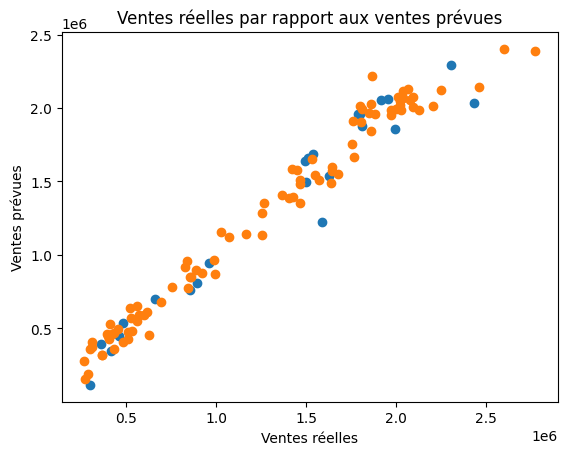

In [45]:
# visualisation des performances du modèle
plt.scatter(y_test, y_test_pred) 
plt.scatter(y_train, y_train_pred) 
plt.xlabel('Ventes réelles') 
plt.ylabel('Ventes prévues') 
plt.title('Ventes réelles par rapport aux ventes prévues') 
plt.show()

In [46]:
# Importance des features
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.coef_.round(2),
    'Coefficient_val_abs': abs(model.coef_).round(2)
}).sort_values(by='Coefficient_val_abs', ascending=False)

feature_importance

,Feature,Coefficient,Coefficient_val_abs
20,cat__Store_5.0,-1431721.10,1431721.10
18,cat__Store_3.0,-1289588.52,1289588.52
24,cat__Store_9.0,-1219338.15,1219338.15
12,cat__Store_16.0,-1174941.57,1174941.57
22,cat__Store_7.0,-997519.54,997519.54
13,cat__Store_17.0,-890858.40,890858.40
23,cat__Store_8.0,-871936.00,871936.00
11,cat__Store_15.0,-847521.91,847521.91
10,cat__Store_14.0,579795.57,579795.57
19,cat__Store_4.0,485247.23,485247.23


In [47]:
px.bar(feature_importance, x='Feature', y='Coefficient_val_abs')

# Partie 3 : Combattre le surapprentissage

### Ridge

In [48]:
# Régression de Ridge 
ridge_model = Ridge() 
ridge_model.fit(X_train, y_train) 

Ridge()

In [49]:
# évaluation du modèle pour l'ensemble d'entraînement
y_train_pred = ridge_model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
print("La performance du Modèle pour le set de Train")
print("---------------------------------------------")
print(f"Score R² : {r2_train:.2f}")
print()

# évaluation du modèle pour le set de test
y_test_pred = ridge_model.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
print("La performance du Modèle pour le set de Test")
print("--------------------------------------------")
print(f"Score R² : {r2_test:.2f}")

La performance du Modèle pour le set de Train
---------------------------------------------
Score R² : 0.93

La performance du Modèle pour le set de Test
--------------------------------------------
Score R² : 0.87


In [50]:
# Recherche du meilleur alpha
params = {'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]}
grid_ridge = GridSearchCV(ridge_model, params, cv = 10, verbose = 0)
grid_ridge.fit(X_train, y_train)

print("Valeur optimale pour alpha : ", grid_ridge.best_params_)
print()

# évaluation du modèle pour l'ensemble d'entraînement
y_train_pred = grid_ridge.best_estimator_.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
print("La performance du Modèle pour le set de Train")
print("---------------------------------------------")
print(f"Score R² : {r2_train:.2f}")
print()

# évaluation du modèle pour le set de test
y_test_pred = grid_ridge.best_estimator_.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
print("La performance du Modèle pour le set de Test")
print("--------------------------------------------")
print(f"Score R² : {r2_test:.2f}")

Valeur optimale pour alpha :  {'alpha': 0.05}

La performance du Modèle pour le set de Train
---------------------------------------------
Score R² : 0.97

La performance du Modèle pour le set de Test
--------------------------------------------
Score R² : 0.95


### Lasso

In [51]:
# Régression de Lasso 
lasso_model = Lasso(max_iter=10000) 
lasso_model.fit(X_train, y_train)

Lasso(max_iter=10000)

In [52]:
# évaluation du modèle pour l'ensemble d'entraînement
y_train_pred = lasso_model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
print("La performance du Modèle pour le set de Train")
print("---------------------------------------------")
print(f"Score R² : {r2_train:.2f}")
print()

# évaluation du modèle pour le set de test
y_test_pred = lasso_model.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
print("La performance du Modèle pour le set de Test")
print("--------------------------------------------")
print(f"Score R² : {r2_test:.2f}")

La performance du Modèle pour le set de Train
---------------------------------------------
Score R² : 0.97

La performance du Modèle pour le set de Test
--------------------------------------------
Score R² : 0.94


In [53]:
# Recherche du meilleur alpha
params = {'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]}
grid_lasso = GridSearchCV(lasso_model, params, cv = 10, verbose = 0)
grid_lasso.fit(X_train, y_train)

print("Valeur optimale pour alpha : ", grid_lasso.best_params_)
print()

# évaluation du modèle pour l'ensemble d'entraînement
y_train_pred = grid_lasso.best_estimator_.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
print("La performance du Modèle pour le set de Train")
print("---------------------------------------------")
print(f"Score R² : {r2_train:.2f}")
print()

# évaluation du modèle pour le set de test
y_test_pred = grid_lasso.best_estimator_.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
print("La performance du Modèle pour le set de Test")
print("--------------------------------------------")
print(f"Score R² : {r2_test:.2f}")

Valeur optimale pour alpha :  {'alpha': 100}

La performance du Modèle pour le set de Train
---------------------------------------------
Score R² : 0.97

La performance du Modèle pour le set de Test
--------------------------------------------
Score R² : 0.95
